# Reproducing results from the paper
In this notebook, the pretrained models are loaded and the results from the paper can be reproduced.

**IMPORTANT**: The results are obtained using Windows 10, there may be slight differences in calculating the UMAPs on other operating systems even when fixing the random_state parameter (by default is 0). https://github.com/lmcinnes/umap/issues/153

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import pandas as pd
import yaml

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.utils_training import init_model, show_umap, determine_marker_genes

In [3]:
%load_ext autoreload
%autoreload 2

#### Set path where the models are saved

In [4]:
base_path = '../saved_models/10x'

Helper function to load the pretrained model easily

In [5]:
def load_model(MODEL_TYPE, DONOR_NR, adata):
    model_fp = f'10x_{MODEL_TYPE.lower()}_donor_{DONOR_NR}.pt'
    file_path = os.path.join(base_path, model_fp)
    model_file = torch.load(file_path)
    params = model_file['params']
    model = init_model(params, model_type=MODEL_TYPE, adata=adata, dataset_name='10x')
    model.load(file_path)
    return model

### Load data

In [6]:
adata_all = sc.read('../data/10x_CD8TC/v6_supervised.h5ad')

### Define a couple of data related variables

List of antigens per donor that has more than 100 cells in the train set

In [7]:
donor_1_high_count_antigens = ['A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                               'A0301_KLGGALQAK_IE-1_CMV_binder',
                               'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                               'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
                               'A0201_ELAGIGILTV_MART-1_Cancer_binder']
donor_2_high_count_antigens = ['B0801_RAKFKQLL_BZLF1_EBV_binder',
                               'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                               'A0301_KLGGALQAK_IE-1_CMV_binder',
                               'A0201_GLCTLVAML_BMLF1_EBV_binder',
                               'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder']

donor_specific_high_count_antigens = {'1': donor_1_high_count_antigens,
                                      '2': donor_2_high_count_antigens}

Reduce the long epitope name only to the sequence for a shorter legend and fix color for each epitope

In [8]:
mapper = {'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 'IVTDFSVIK',
          'A0301_KLGGALQAK_IE-1_CMV_binder': 'KLGGALQAK',
          'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 'GILGFVFTL',
          'A0201_ELAGIGILTV_MART-1_Cancer_binder': 'ELAGIGILTV', 
          'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 'AVFDRKSDAK',
          'A0201_GLCTLVAML_BMLF1_EBV_binder': 'GLCTLVAML',
          'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 'RLRAEAQVK',
          'B0801_RAKFKQLL_BZLF1_EBV_binder': 'RAKFKQLL'}

color_palette = {'IVTDFSVIK': 'tab:green',
                 'KLGGALQAK': 'tab:red', 
                 'GILGFVFTL': 'tab:orange',
                 'ELAGIGILTV': 'tab:blue',
                 'AVFDRKSDAK': 'tab:pink',
                 'GLCTLVAML': 'tab:brown',
                 'RLRAEAQVK': 'tab:purple',
                 'RAKFKQLL': 'tab:olive'}

Load used UMAP and plot parameters to get the figures from the paper

In [9]:
umap_params = yaml.safe_load(open(os.path.join(base_path, 'umap_params.yaml'), 'r'))

# Evaluate Models with kNN and cluster scores

k-Nearest Neighbor classification is used on the latent representation to impute antigen specificity of the query set (test) with the atlas set (train). Results are stored in the results dict.

Evaluate the quality of clusters using the two metrics
- Average Silhouette Width: Measures how clear the clusters are separated
- Normalized Mutual Information: Harmonic mean between completeness (are all cells with the same antigen specificity in the same cluster or spread over multiple clusters?) and pureness (do the determined clusters contain only one antigen specificity or multiple?)
Clusters are determined using Leiden

In [10]:
results_list = []
for DONOR_NR in ['1', '2']:
    adata = adata_all[adata_all.obs['donor'] == 'donor_'+DONOR_NR]
    adata = adata[adata.obs['binding_name'].isin(donor_specific_high_count_antigens[DONOR_NR])]
    adata.obs['binding_name'] = adata.obs['binding_name'].astype(str)
    
    for MODEL_TYPE in ['RNA', 'TCR', 'concat', 'PoE']:
        results = {'donor': DONOR_NR, 'model_type': MODEL_TYPE}  # dict saving the results, later will be converted to pd.DataFrame
        
        model = load_model(MODEL_TYPE, DONOR_NR, adata)
        test_embedding_func = get_model_prediction_function(model, batch_size=1024)  # helper function for evaluation functions

        summary = run_imputation_evaluation(adata, test_embedding_func, query_source='test', use_non_binder=False, use_reduced_binders=True, num_neighbors=5)
        results['kNN weighted f1-score'] = summary['knn']['weighted avg']['f1-score']
        
        cluster_results = run_clustering_evaluation(adata, test_embedding_func, 'all', name_label='binding_name', 
                                           cluster_params={'resolution': umap_params[DONOR_NR][MODEL_TYPE]['resolution'], 
                                                           'num_neighbors': 5})
        results['ASW'] = cluster_results['ASW']
        results['NMI'] = cluster_results['NMI']

        results_list.append(results)
pd.set_option('precision', 2)
pd.DataFrame(results_list)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


,donor,model_type,kNN weighted f1-score,ASW,NMI
0,1,RNA,0.73,0.14,0.47
1,1,TCR,0.67,-0.32,0.41
2,1,concat,0.73,0.22,0.57
3,1,PoE,0.69,0.24,0.48
4,2,RNA,0.75,0.04,0.32
5,2,TCR,0.86,-0.39,0.33
6,2,concat,0.87,0.24,0.36
7,2,PoE,0.90,0.41,0.34


# Plot UMAPs colored by epitope specificity
Calculate UMAP and visualize. Each color indicates a different antigen specificity

################################################# DONOR 1 #################################################


Trying to set attribute `.obs` of view, copying.


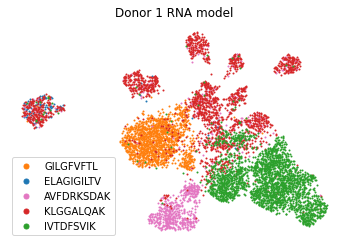

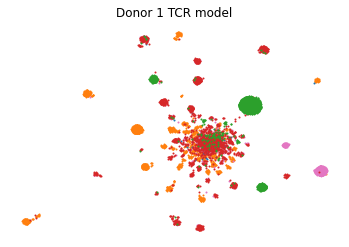

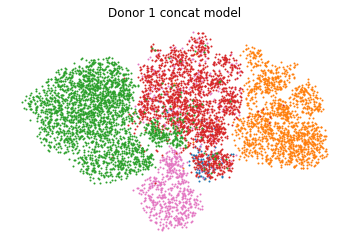

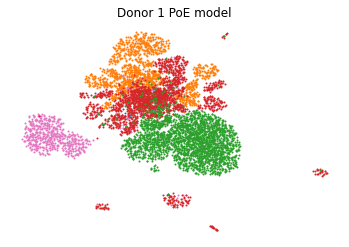

################################################# DONOR 2 #################################################


Trying to set attribute `.obs` of view, copying.


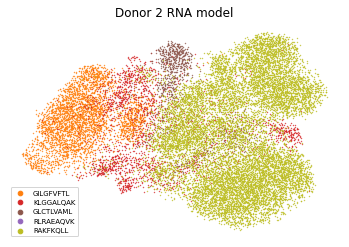

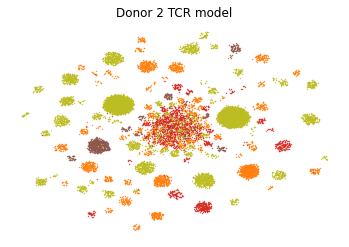

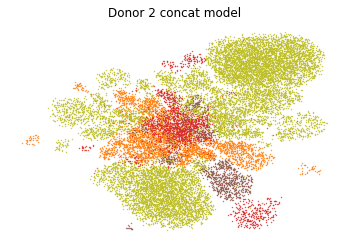

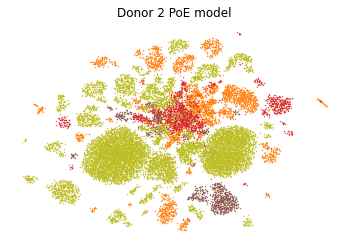

In [11]:
for DONOR_NR in ['1', '2']:
    print(f'################################################# DONOR {DONOR_NR} #################################################')
    adata = adata_all[adata_all.obs['donor'] == 'donor_'+DONOR_NR]
    adata = adata[adata.obs['binding_name'].isin(donor_specific_high_count_antigens[DONOR_NR])]
    adata = adata[adata.obs['set'] == 'train']
    adata.obs['binding_name'] = adata.obs['binding_name'].astype(str)
    adata.obs['binding_clear_name'] = adata.obs['binding_name'].map(mapper)
    for MODEL_TYPE in ['RNA', 'TCR', 'concat', 'PoE']:
        model = load_model(MODEL_TYPE, DONOR_NR, adata)
        test_embedding_func = get_model_prediction_function(model, batch_size=1024)  # helper function for evaluation functions
        
        latent = test_embedding_func(adata)
        adata.obsm['latent'] = latent
        sc.pp.neighbors(adata, use_rep='latent')
        sc.tl.umap(adata, min_dist=umap_params[DONOR_NR][MODEL_TYPE]['min_dist'], 
          spread=umap_params[DONOR_NR][MODEL_TYPE]['spread'], random_state=0)
        for epitope in umap_params[DONOR_NR]['epitopes']:
            xy = adata[adata.obs['binding_clear_name'] == epitope].obsm['X_umap']
            plt.scatter(xy[:, 0], xy[:, 1], s=umap_params[DONOR_NR]['marker_size'], label=epitope, c=color_palette[epitope])
        plt.xticks([])
        plt.yticks([])
        plt.box(False)
        plt.title(f'Donor {DONOR_NR} {MODEL_TYPE} model')
        if MODEL_TYPE == 'RNA':
            plt.legend(markerscale=umap_params[DONOR_NR]['markerscale'], fontsize=umap_params[DONOR_NR]['fontsize'])
        plt.show()

# Differential gene expression

First we determine the Top 1 marker genes on the preprocessed transcriptomics data of each Leiden cluster.

################################################# DONOR 1 #################################################


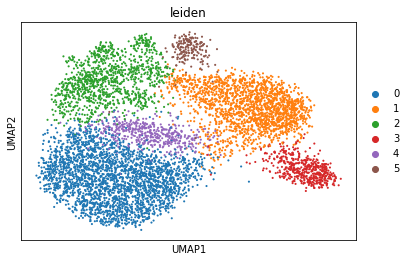

Trying to set attribute `.uns` of view, copying.


################################################# DONOR 2 #################################################


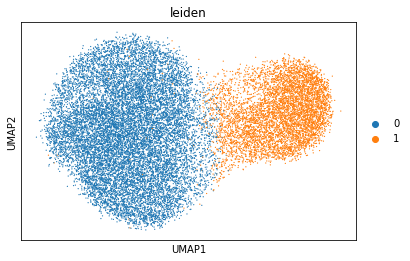

Trying to set attribute `.uns` of view, copying.


In [12]:
marker_genes = {}
for DONOR_NR in ['1', '2']:
    print(f'################################################# DONOR {DONOR_NR} #################################################')
    adata = adata_all[adata_all.obs['donor'] == 'donor_'+DONOR_NR]
    adata = adata[adata.obs['binding_name'].isin(donor_specific_high_count_antigens[DONOR_NR])]
    adata = adata[adata.obs['set'] == 'train']
    marker_genes[DONOR_NR] = determine_marker_genes(adata, resolution=umap_params[DONOR_NR]['DGE']['resolution'], visualize=True)

Print the determined Top 1 Marker genes for each Leiden cluster.

In [13]:
marker_genes

{'1': ['CMC1', 'IL7R', 'GZMH', 'LEF1', 'GZMK', 'NKG7'], '2': ['GZMH', 'IL7R']}

Visualize the normalized and log-transformed gene expression of the determined marker genes

################################################# DONOR 1 #################################################


Trying to set attribute `.obs` of view, copying.


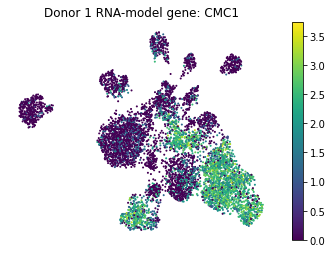

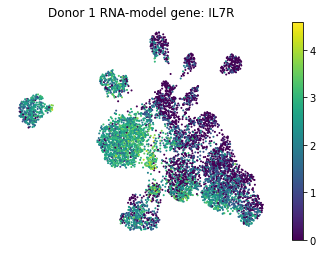

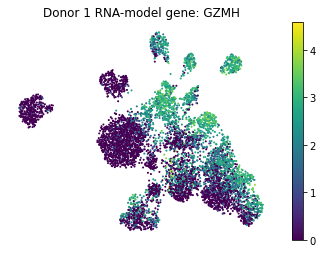

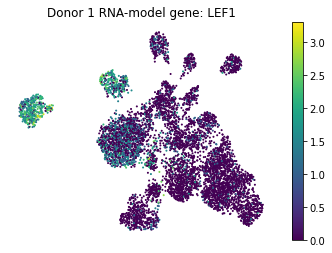

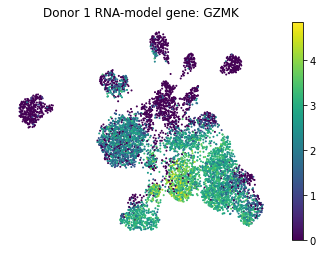

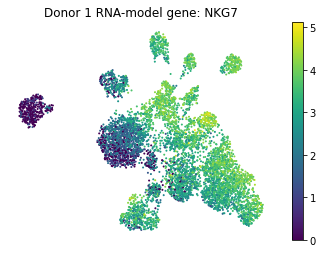

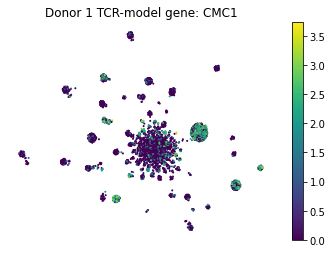

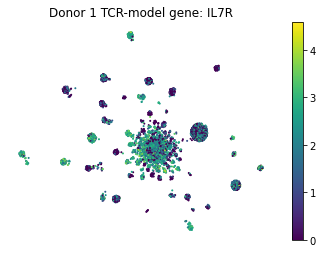

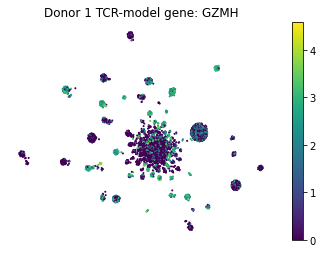

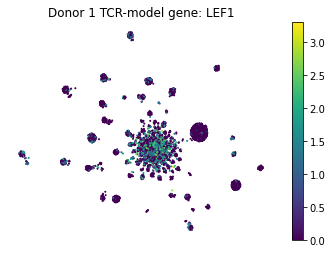

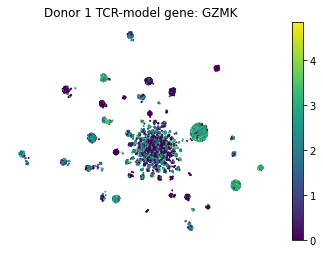

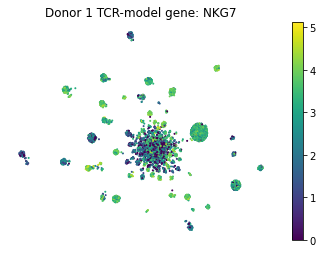

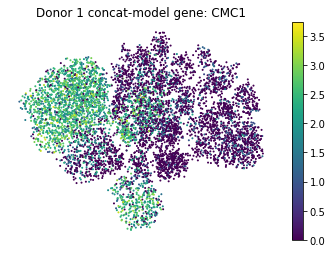

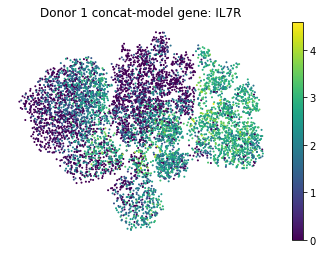

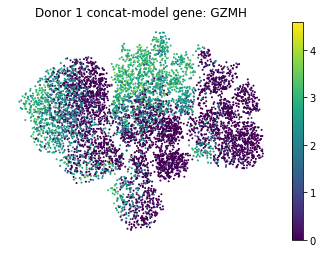

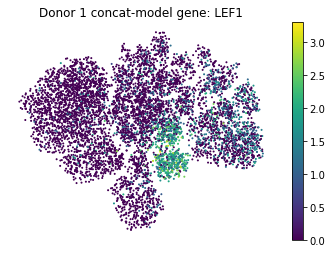

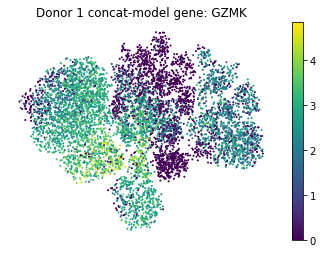

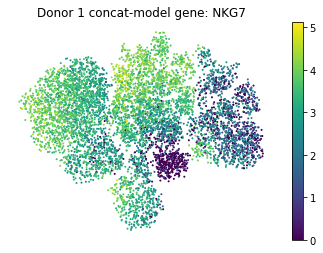

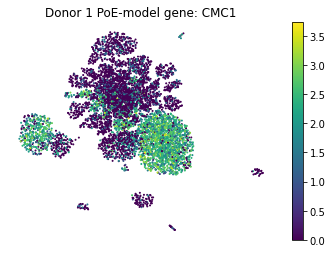

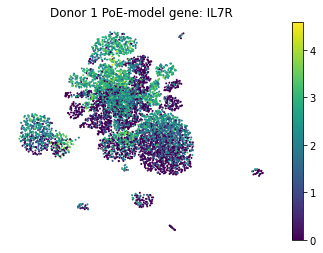

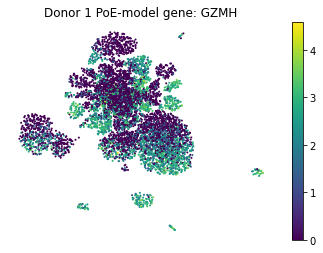

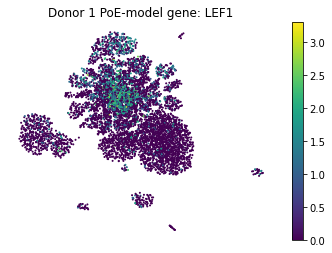

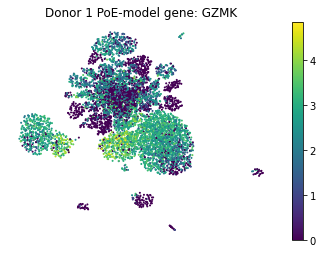

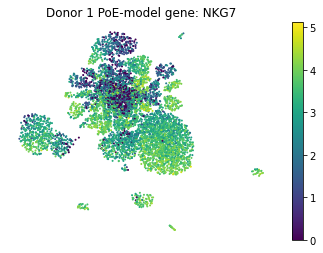

################################################# DONOR 2 #################################################


Trying to set attribute `.obs` of view, copying.


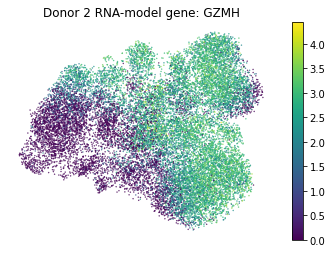

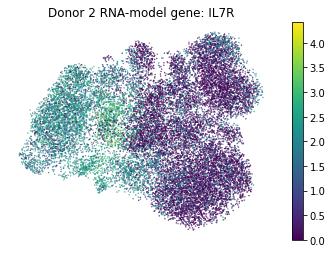

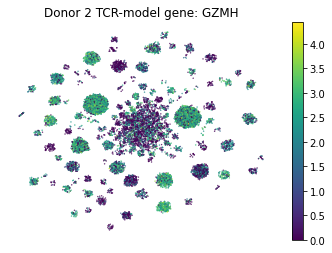

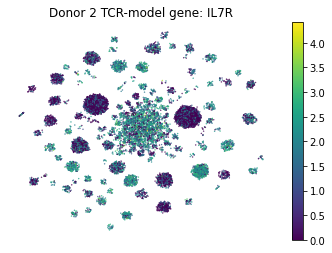

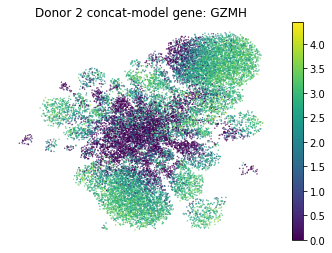

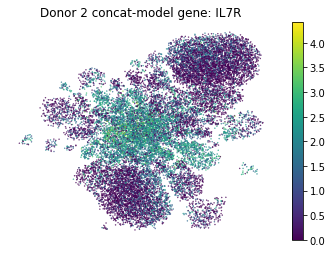

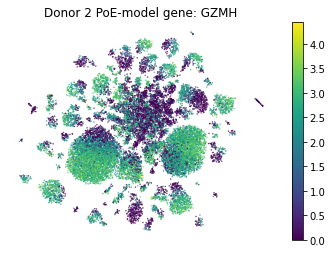

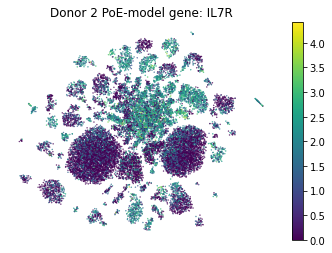

In [17]:
for DONOR_NR in ['1', '2']:
    print(f'################################################# DONOR {DONOR_NR} #################################################')
    adata = adata_all[adata_all.obs['donor'] == 'donor_'+DONOR_NR]
    adata = adata[adata.obs['binding_name'].isin(donor_specific_high_count_antigens[DONOR_NR])]
    adata = adata[adata.obs['set'] == 'train']
    adata.obs['binding_name'] = adata.obs['binding_name'].astype(str)

    for MODEL_TYPE in ['RNA', 'TCR', 'concat', 'PoE']:
        model = load_model(MODEL_TYPE, DONOR_NR, adata)
        test_embedding_func = get_model_prediction_function(model, batch_size=1024)  # helper function for evaluation functions
        
        latent = test_embedding_func(adata)
        adata.obsm['latent'] = latent
        sc.pp.neighbors(adata, use_rep='latent')
        sc.tl.umap(adata, min_dist=umap_params[DONOR_NR][MODEL_TYPE]['min_dist'], 
          spread=umap_params[DONOR_NR][MODEL_TYPE]['spread'], random_state=0)

        for marker_gene in marker_genes[DONOR_NR]:
            xy = adata.obsm['X_umap']
            c = np.array(adata[:, marker_gene].X.todense())[:,0]
            ax = plt.scatter(xy[:, 0], xy[:, 1], c=c, s=umap_params[DONOR_NR]['marker_size'])
            plt.colorbar(ax)
            plt.xticks([])
            plt.yticks([])
            plt.box(False)
            plt.title(f'Donor {DONOR_NR} {MODEL_TYPE}-model gene: {marker_gene}')
            plt.show()